In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.optimize as opt
from scipy import io
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')


# For 3d plot
from mpl_toolkits.mplot3d import axes3d, Axes3D
from matplotlib import cm
import itertools

# very limited information when exception is caught
%xmode Plain
# %pdb on or %ipdb on # enable debugger when exception occurred

Exception reporting mode: Plain


In [3]:
ex3data = io.loadmat(os.path.join('data', 'ex3data1.mat'))
X = ex3data['X']
y = ex3data['y']
list(ex3data.keys()), X.shape, y.shape

(['__header__', '__version__', '__globals__', 'X', 'y'],
 (5000, 400),
 (5000, 1))

In [4]:
np.unique(y)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=uint8)

In [12]:
rand_indices = np.random.choice(y.size, 100, replace = False)
sel = X[rand_indices, :]
sel.shape

(100, 400)

In [83]:
def displayImg(X, example_width = None, figsize=(10, 10)):
    if X.ndim == 2:
        m, n = X.shape
    elif X.ndim == 1:
        n = X.size
        m = 1
        X = X[None]
    else:
        raise IndexError('Input X should be 1 or 2 dimensional array')
    print('m = %s, n = %s' %(m, n))
    example_width = example_width or int(np.round(np.sqrt(n)))
    example_height = int(n / example_width)
    print('example_width = %s, example_height = %s' %(example_width, example_height))
          
    display_rows = int(np.floor(np.sqrt(m)))
    display_cols = int(np.ceil( m / display_rows))
    print('d_rows = %s, s_cols = %s' %(display_rows, display_cols))
    
    fig, ax_array = plt.subplots(display_rows, display_cols, figsize=figsize)
    fig.subplots_adjust(wspace = 0.025, hspace = 0.025)
    ax_array = [ax_array] if m == 1 else ax_array.ravel()
    
    for i, ax in enumerate(ax_array):
        ax.imshow(X[i].reshape(example_width, example_height, order = 'F'), cmap = 'Greys', extent = [0, 1, 0, 1])
        ax.axis('off')
    

m = 100, n = 400
example_width = 20, example_height = 20
d_rows = 10, s_cols = 10


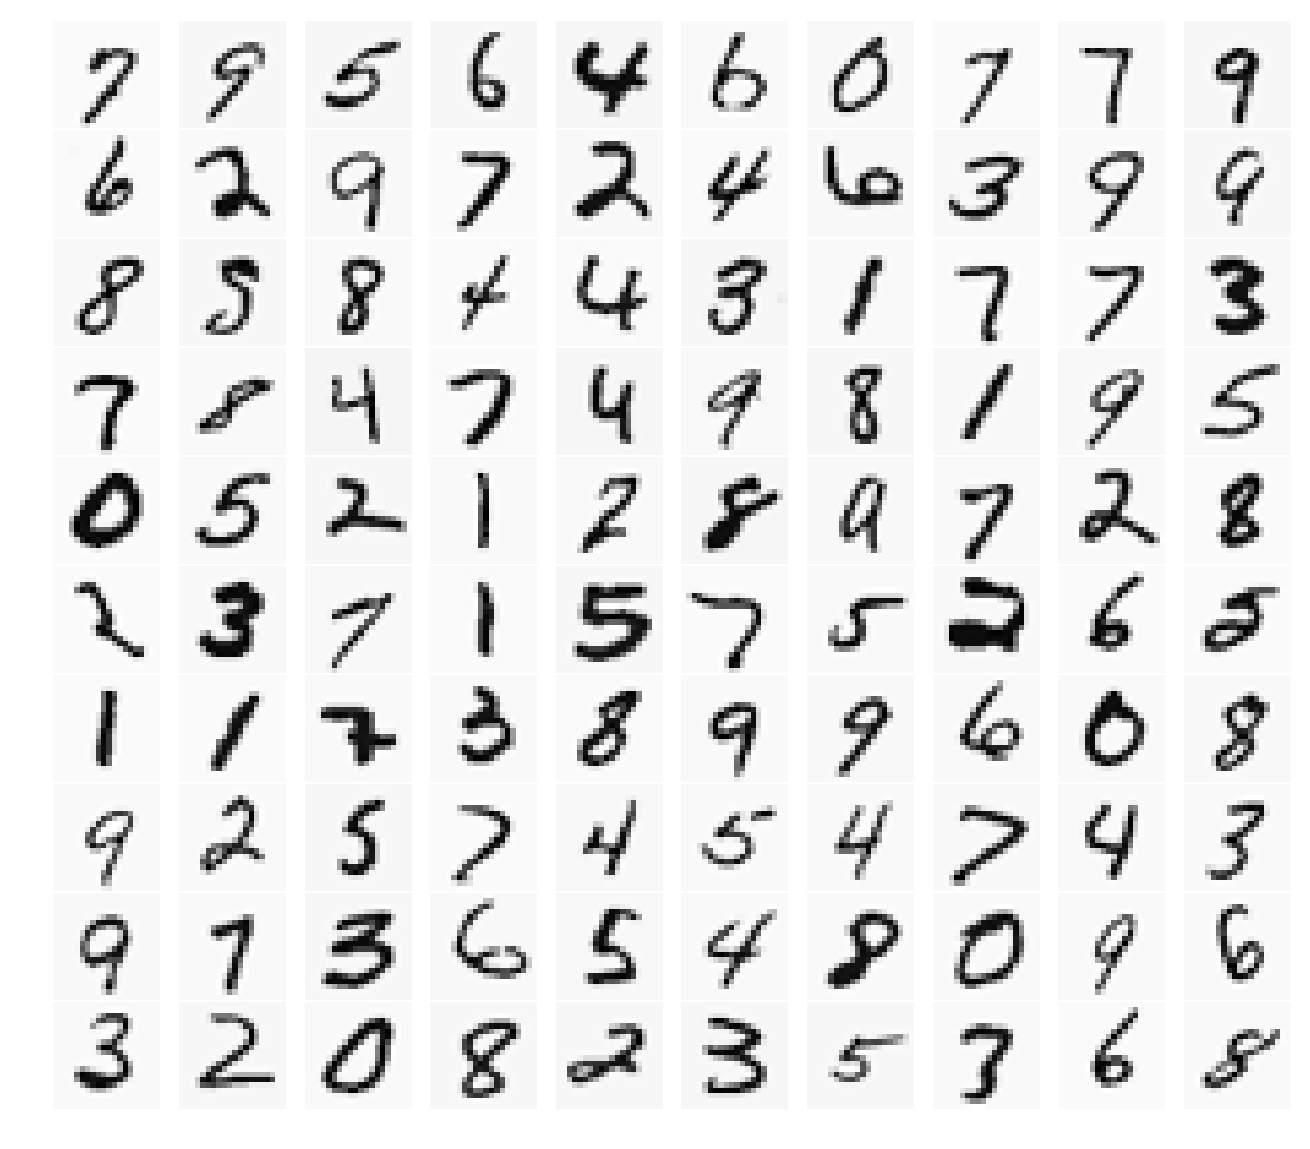

In [84]:
displayImg(sel)